<a href="https://colab.research.google.com/github/MingNhayMua/AIO_Convolutional-Neural-Network_excercise/blob/main/ResNet_Weather_Img_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive

Mounted at /content/drive
cp: missing destination file operand after '/path/to/dataset/on/your/drive'
Try 'cp --help' for more information.


In [5]:
# https://drive.google.com/file/d/1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0/view?usp=drive_link
!gdown --id 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=8ae7944e-bfb3-4550-ae78-7f9e561f2416
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:05<00:00, 104MB/s]


In [6]:
!unzip img_cls_weather_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-data

## **1. Import libraries**

In [7]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## **2. Read dataset**

In [9]:
root_dir = 'weather-dataset/dataset' ##thu muc goc
classes = {
    label_idx: class_name
    for label_idx, class_name in enumerate(sorted(os.listdir(root_dir))) ##os.listdir lay ra cac thu muc trong thu muc goc
    if os.path.isdir(os.path.join(root_dir, class_name))  # Kiểm tra chỉ lấy thư mục
}##tao class gan label

img_paths = []
labels = []
for label_idx, class_name in classes.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_filename)
        img_paths.append(img_path)
        labels.append(label_idx)

## **3. Train, val, test split**

In [10]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

## **4. Create pytorch dataset**

In [11]:
class WeatherDataset(Dataset):
    def __init__(
        self,
        X, y,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB') ##Mở hình ảnh từ đường dẫn
                                                    ##và chuyển đổi nó thành hình ảnh màu RGB.

        if self.transform:
            img = self.transform(img)

        return  img, self.labels[idx]

## **5. Create data preprocessing function**

In [12]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img = np.array(img)[..., :3]
    img = torch.tensor(img).permute(2,0,1).float() ##Mảng NumPy này có dạng (H, W, C), trong đó H là chiều cao, W là chiều rộng và C là số kênh màu (RGB có 3 kênh).
    normalized_img = img/255.0
    return normalized_img

## **6. Create dataloader**

In [13]:
train_dataset = WeatherDataset(
    X_train, y_train,
    transform=transform
)
val_dataset = WeatherDataset(
    X_val, y_val,
    transform=transform
)
test_dataset = WeatherDataset(
    X_test, y_test,
    transform=transform
)

In [14]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

Feature batch shape: torch.Size([512, 3, 224, 224])
Labels batch shape: torch.Size([512])


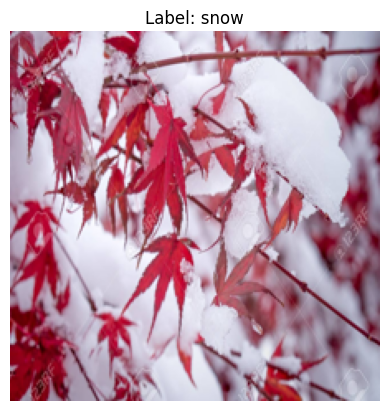

In [15]:
train_features, train_labels = next(iter(train_loader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].permute(1, 2, 0)
label = train_labels[0].item()
plt.imshow(img)
plt.axis('off')
plt.title(f'Label: {classes[label]}')
plt.show()

## **7. Create model**

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels , out_channels, kernel_size = 3, stride = stride , padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1 , stride = stride, padding = 0),
                nn.BatchNorm2d(out_channels)
            )
        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = x.clone()  # Lưu bản sao của x (shortcut)
        x = self.conv1(x)     # Áp dụng lớp conv1
        x = self.batch_norm1(x)  # Áp dụng batch normalization
        x = self.relu(x)      # Áp dụng ReLU activation
        x = self.conv2(x)     # Áp dụng lớp conv2
        x = self.batch_norm2(x)  # Áp dụng batch normalization
        x += self.downsample(shortcut)  # Shortcut kết hợp với đầu ra của x
        x = self.relu(x)      # Áp dụng ReLU activation cho kết quả cuối cùng
        return x  # Trả về đầu ra cuối cùng


In [69]:
class ResNet(nn.Module):
    def __init__(self, residual_block, n_blocks_lst, n_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64 , kernel_size =  7 , stride = 2 , padding = 3)
        self.BatchNorm1 = nn.BatchNorm2d(64)
        self.MaxPooling = nn.MaxPool2d(kernel_size = 3 , stride = 2 , padding = 1)
        self.conv2 = self.create_layer(residual_block, 64, 64, n_blocks_lst[0], 1)
        self.conv3 = self.create_layer(residual_block, 64, 128, n_blocks_lst[1], 2)
        self.conv4 = self.create_layer(residual_block , 128 , 256, n_blocks_lst[2], 2)
        self.conv5 = self.create_layer(residual_block, 256, 512, n_blocks_lst[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(512, n_classes)
        self.relu = nn.ReLU()
    def create_layer(self, residual_block, in_channels, out_channels, n_blocks, stride):
        blocks = []
        first_block = residual_block(in_channels, out_channels, stride)
        blocks.append(first_block)
        for i in range(1, n_blocks):
            block = residual_block(out_channels, out_channels, stride = stride)
            blocks.append(block)

        return nn.Sequential(*blocks)

    def forward(self, x):
        outputs = x
        outputs = self.conv1(outputs)
        outputs = self.BatchNorm1(outputs)
        outputs = self.MaxPooling(outputs)
        outputs = self.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        outputs = self.conv4(outputs)
        outputs = self.conv5(outputs)
        outputs = self.avg_pool(outputs)
        outputs = nn.Flatten()(outputs)
        outputs = self.fc1(outputs)

        return outputs

In [70]:
n_classes = len(list(classes.keys()))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    residual_block=ResidualBlock,
    n_blocks_lst=[2, 2, 2, 2],
    n_classes=n_classes
).to(device)

In [71]:
model.eval()

dummy_tensor = torch.randn(1, 3, 224, 224).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([1, 11])


## **8. Training**

In [72]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [73]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [74]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr
)

In [75]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

EPOCH 1:	Train loss: 1.9038	Val loss: 2.4077
EPOCH 2:	Train loss: 1.2992	Val loss: 2.4363
EPOCH 3:	Train loss: 1.0292	Val loss: 2.4046
EPOCH 4:	Train loss: 0.8634	Val loss: 2.2785
EPOCH 5:	Train loss: 0.6978	Val loss: 1.6448
EPOCH 6:	Train loss: 0.5876	Val loss: 1.1226
EPOCH 7:	Train loss: 0.4196	Val loss: 1.1564
EPOCH 8:	Train loss: 0.3735	Val loss: 1.1964
EPOCH 9:	Train loss: 0.2408	Val loss: 1.2644
EPOCH 10:	Train loss: 0.1981	Val loss: 1.0776
EPOCH 11:	Train loss: 0.1524	Val loss: 1.0124
EPOCH 13:	Train loss: 0.0872	Val loss: 0.9921
EPOCH 14:	Train loss: 0.0691	Val loss: 1.0264
EPOCH 15:	Train loss: 0.0542	Val loss: 0.9987
EPOCH 16:	Train loss: 0.0469	Val loss: 0.9966
EPOCH 17:	Train loss: 0.0383	Val loss: 0.9926
EPOCH 18:	Train loss: 0.0357	Val loss: 0.9880
EPOCH 19:	Train loss: 0.0305	Val loss: 1.0136
EPOCH 20:	Train loss: 0.0270	Val loss: 1.0037
EPOCH 21:	Train loss: 0.0220	Val loss: 1.0005
EPOCH 22:	Train loss: 0.0216	Val loss: 1.0098
EPOCH 23:	Train loss: 0.0200	Val loss: 1.00

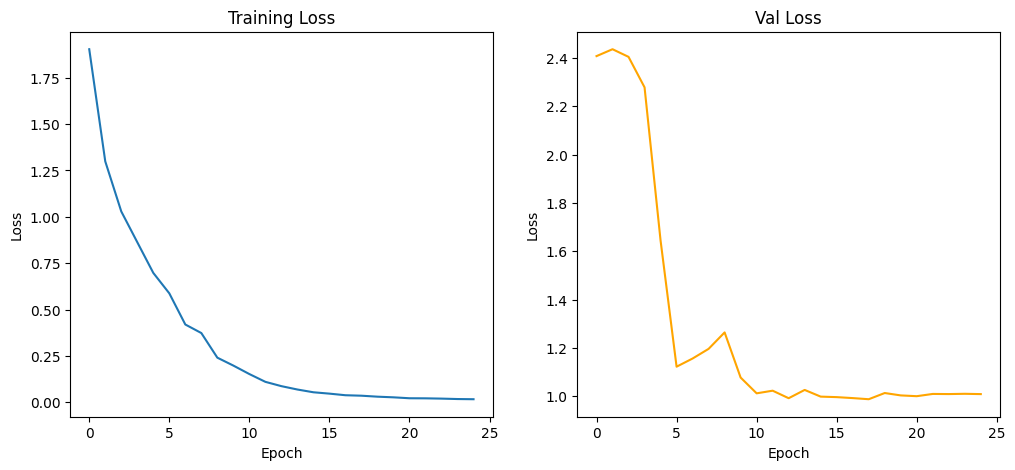

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## **9. Evaluation**

In [77]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6824471959213402
Test accuracy:  0.6648451730418944
